<a href="https://colab.research.google.com/github/upriyam-cmu/EDGE-Rec/blob/main/execute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install project code

In [ ]:
!pip uninstall -y edge-rec
!pip install -e.

# Train model

In [1]:
from edge_rec.datasets import MovieLensDataHolder, RatingsTransform, FeatureTransform

from edge_rec.model import GraphReconstructionModel, GraphTransformer
from edge_rec.model.embed import MovieLensFeatureEmbedder, SinusoidalPositionalEmbedding

from edge_rec.diffusion import GaussianDiffusion
from edge_rec.exec import Trainer, compute_metrics_from_ratings as compute_metrics

In [2]:
data_holder = MovieLensDataHolder(augmentations=dict(
    ratings=RatingsTransform.ToGaussian(),
    rating_counts=FeatureTransform.LogPolynomial(2),  # degree 2 --> dim_size = 2 (for embedder, below)
))

In [3]:
embed = MovieLensFeatureEmbedder(
    user_age_dim=2,
    user_gender_dim=1,
    user_occupation_dim=3,
    user_rating_counts_dims=2,
    movie_genre_ids_dim=6,
    movie_rating_counts_dims=2,
)
core = GraphTransformer(
    n_blocks=4,
    n_channels=1,
    n_channels_internal=3,
    n_features=embed.output_sizes,
    time_embedder=SinusoidalPositionalEmbedding(16),
    attn_kwargs=dict(heads=2, dim_head=8, num_mem_kv=1, speed_hack=True, share_weights=False),
)
model = GraphReconstructionModel(embed, core, feature_dim_size=None)

In [5]:
diffusion_model = GaussianDiffusion(model, image_size=64)
trainer = Trainer(
    # model
    diffusion_model=diffusion_model,
    # datasets
    train_dataset=data_holder.get_dataset(subgraph_size=64, target_density=None, train=True),
    test_dataset=data_holder.get_dataset(subgraph_size=64, target_density=None, train=False),
    # training
    batch_size=16,
    gradient_accumulate_every=1,
    force_batch_size=True,
    train_num_steps=int(1e4),
    train_mask_unknown_ratings=True,
    # eval
    eval_batch_size=None,  # copy training batch size if None
    n_eval_iters=3,
    eval_every=200,
    sample_on_eval=False,
    # optim
    train_lr=1e-4,
    adam_betas=(0.9, 0.99),
    max_grad_norm=1.,
    # logging
    results_folder="./results",
    ema_update_every=10,
    ema_decay=0.995,
    save_every_nth_eval=5,
    # accelerator
    amp=False,
    mixed_precision_type='fp16',
    split_batches=True,
)
print("Using device:", trainer.device)

Using device: mps


In [ ]:
trainer.train()

# Sample ratings

In [17]:
def eval_model(use_inpainting: bool, milestone: int):
    user_indices, product_indices = data_holder.get_subgraph_indices(50, 0.7)  # full graph
    rating_data_train = data_holder.slice_subgraph(
        user_indices=user_indices,
        product_indices=product_indices,
        return_train_edges=True,
        return_test_edges=False,
    )
    rating_data_test = data_holder.slice_subgraph(
        user_indices=user_indices,
        product_indices=product_indices,
        return_train_edges=False,
        return_test_edges=True,
    )
    denoised_graph = trainer.eval(
        rating_data=rating_data_train.clone(),
        milestone=milestone,
        do_inpainting_sampling=use_inpainting,
        tiled_sampling=False,
        # batch_size=16,
        # subgraph_size=128,
        silence_inner_tqdm=True,
    )
    return denoised_graph, rating_data_train, rating_data_test

In [18]:
denoised_graph, rating_data_train, rating_data_test = eval_model(use_inpainting=True, milestone=100000)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
test_ratings = rating_data_test.ratings[rating_data_test.known_mask]
test_ratings = data_holder.ratings_transform.invert(test_ratings)
test_ratings.min()

tensor(2.1094)

# Evaluate metrics

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

mpl.rcParams.update({'figure.dpi': 300, 'font.size': 4})
plt.style.use('bmh')

hrv_name = {
    'precision': 'Precision',
    'recall': 'Recall',
    'mean_reciprocal_rank': 'MRR',
    'hit_rate': 'HR',
    'ndcg': 'NDCG'
}


def plot_metrics(metrics: dict, plot_name: str):
    def _plot(ax, curve_name):
        ax.set_title(hrv_name[curve_name])
        ks = (1, 5, 10, 20, 30, 40, 50)
        ax.xaxis.grid(True, which='major')
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.plot(ks, metrics[curve_name], '.-', linewidth=1.0, markersize=4.0)
        ax.set_xlabel("Top-K")
        ax.set_aspect(50 / (np.max(metrics[curve_name]) - np.min(metrics[curve_name])))

    fig, axs = plt.subplots(1, 5)
    for ax, name in zip(axs, ['precision', 'recall', 'ndcg', 'mean_reciprocal_rank', 'hit_rate']):
        _plot(ax, name)
        if name == 'precision':
            ax.set_ylabel(plot_name)
    plt.tight_layout(h_pad=-25.0)
    plt.show()

In [19]:
metrics = compute_metrics(
    predicted_graph=denoised_graph,
    train_rating_data=rating_data_train,
    test_rating_data=rating_data_test,
    rating_transform=RatingsTransform.ShiftScale(shift=3, scale=2.5),  #data_holder.ratings_transform,
)

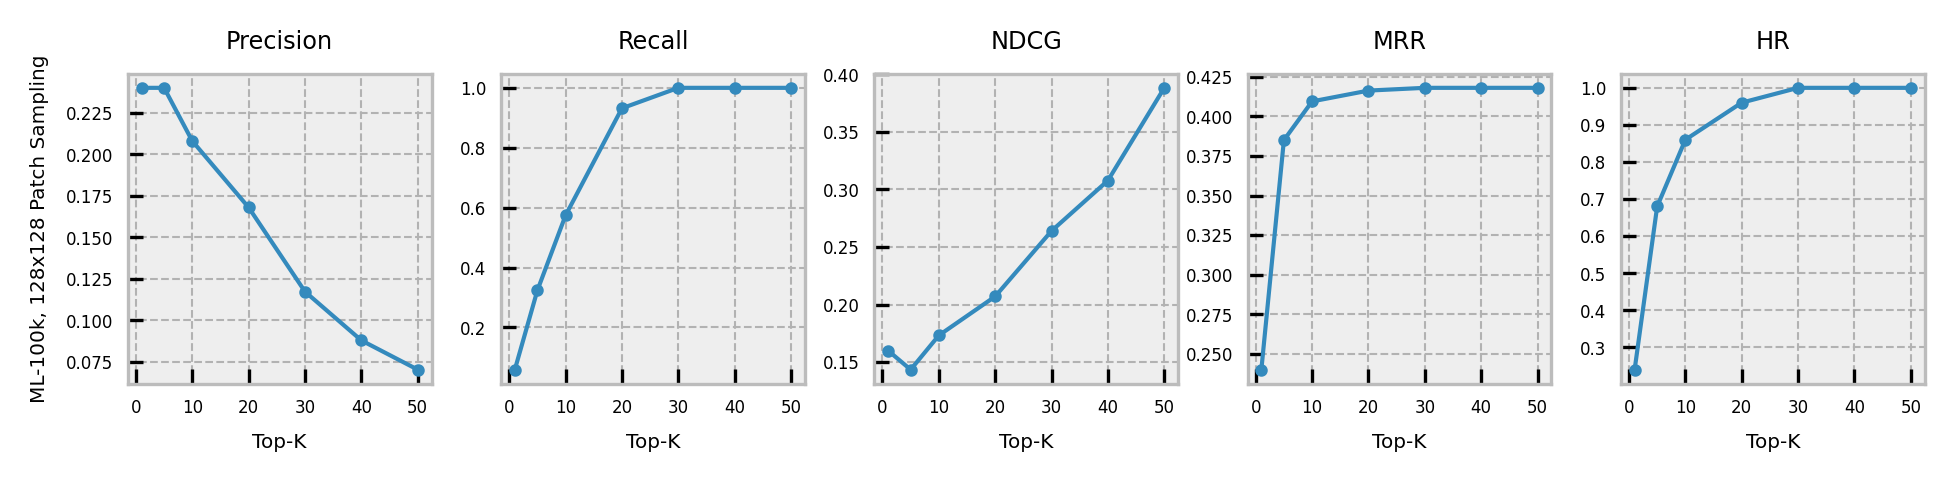

In [20]:
plot_metrics(metrics=metrics, plot_name="ML-100k, 128x128 Patch Sampling")

# Display sampled ratings distribution

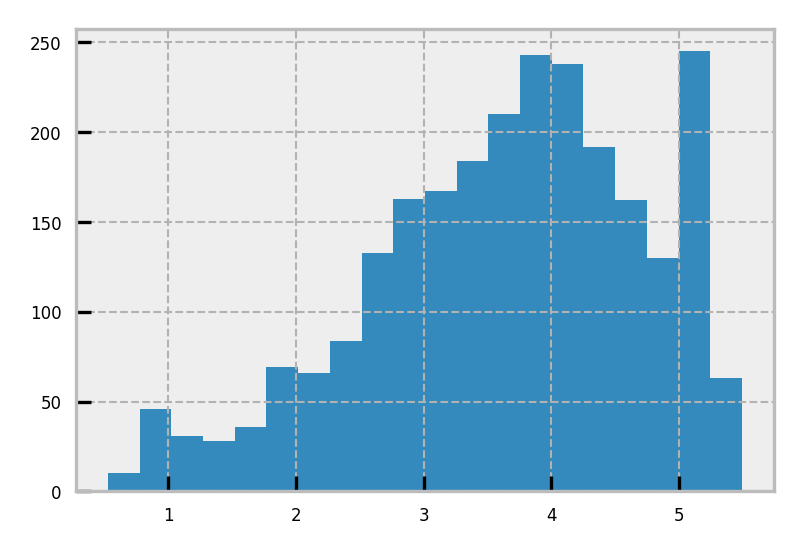

In [14]:
plt.figure(figsize=(3, 2))
plt.hist(data_holder.ratings_transform.invert(denoised_graph).numpy().flatten(), bins=20)
plt.show()

In [ ]:
sum(p.numel() for p in trainer.model.parameters())